# Assignment 5: Ridge Regression
*(continued from Assignment 4)*

For this assignment standard libraries such as `numpy` and `matplotlib` are sufficient.

List your team members (name, matriculation number, course of study) in the following cell:

* Your names here

## Ridge Regression for Time-Series Prediction

In the remaining of this task, you will implement and evaluate a ridge regression model at the example of the lake model. Make sure the provided `lake.dat` file is in the same directory as the Jupyter notebook.

You can find the original data including references here: [DaISy - Data of a simulation of the western basin of Lake Erie](https://homes.esat.kuleuven.be/~smc/daisy/daisydata.html).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

In [3]:
def load_lake_data():
    with open("lake.dat") as f:
        data = np.loadtxt(f)
    X = data[:, 6:11]
    Y = data[:, 23:25]
    return X, Y


def train_test_split(X, Y, train_fraction):
    cutoff_idx = int(train_fraction * X.shape[0])
    X_train, Y_train = X[:cutoff_idx], Y[:cutoff_idx]
    X_test, Y_test = X[cutoff_idx:], Y[cutoff_idx:]

    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = train_test_split(
    *load_lake_data(), train_fraction=0.7
)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Train samples: 39, Test samples: 18


Training data is stored in `X_train` and `Y_train`. Test data is stored in `X_test` and `Y_test`.

1\) *(Assignment 4)*: Create a plot that shows all inputs and outputs of the training dataset over time. For each variable a separate subplot should be created. Time should be displayed along the x-axis, while the value of each variable should be displayed along the y-axis.

*Hint:* Use `plt.subplots(n, sharex=True)` to create `n` plots that are synchronized along the x-axis.

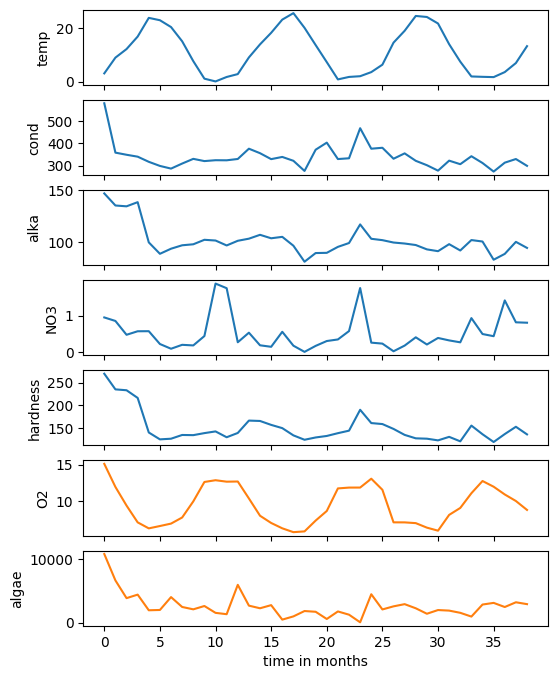

In [4]:
input_names = ("temp", "cond", "alka", "NO3", "hardness")
output_names = ("O2", "algae")

fig, ax = plt.subplots(X_train.shape[1] + Y_train.shape[1], sharex=True, figsize=(6, 8))
XY = np.hstack((X_train, Y_train))
for idx, name in enumerate(input_names + output_names):
    line_color = "C0" if idx < X_train.shape[1] else "C1"
    ax[idx].plot(XY[:, idx], color=line_color)
    ax[idx].set_ylabel(name)
ax[-1].set_xlabel("time in months");

2\) *(Assignment 4)* The `make_features` takes as input a matrix of inputs `X` and a matrix of outputs `Y`, as well as the arguments `feature_type` and `lag`.
It computes a features used as input for a linear regression.


`X` has the shape `(T, 5)` and `Y` has the shape `(T, 2)` where `T` is a number of time steps.
`feature_type` is a string with either value `lin` or `quad` whether only linear features or also quadratic features should be computed. `lag` is a boolean that determines whether the lag variables for `t-1`should be included (see Task 1.5).


If `lag` is False, the returned feature matrix has shape `(T, D)` where `D` depends on the choice of `feature_type`.
For `feature_type=lin` and `lag=False`, `D` equals `5+2+1`, for `feature_type=lin` and `lag=True`, `D` equals `2*(5+2)+1`.
If `lag` is True, the returned feature matrix has shape `(T-1, D)`, since the additional lag variable prevents the creation of a feature for time step $t=0$.


Extend the `make_features` method to also compute quadratic features (`ftype = 'quad'`) for both `lag=False` and `lag=True`.


In [1]:
def make_features(X, Y, feature_type="lin", lag=False):
    if feature_type == "lin":
        if lag:
            Phi = np.hstack(
                (
                    np.ones((X.shape[0] - 1, 1)),  # bias/intercept term
                    X[1:],  # x_t
                    X[:-1],  # x_{t-1}
                    Y[1:],  # y_t
                    Y[:-1],  # y_{t-1}
                )
            )
        else:
            Phi = np.hstack(
                (np.ones((X.shape[0], 1)), X, Y)  # bias/intercept term  # x_t  # y_t
            )
    elif feature_type == "quad":
        features = [np.ones((X.shape[0] - 1, 1)) if lag else np.ones((X.shape[0], 1))]
        XY = np.hstack((X, Y))
        if lag:
            features.append(XY[1:])
            features.append(XY[:-1])
        else:
            features.append(XY)
        for i in range(XY.shape[1]):
            for j in range(i, XY.shape[1]):
                if lag:
                    features.append((XY[1:, i] * XY[1:, j]).reshape(-1, 1))
                    features.append((XY[:-1, i] * XY[:-1, j]).reshape(-1, 1))
                else:
                    features.append((XY[:, i] * XY[:, j]).reshape(-1, 1))
        Phi = np.hstack(features)
    else:
        raise ValueError(f"feature_type is not implemented for {feature_type}")

    return Phi

### Task 1 (*Assignment 5*)
1\) Implement a linear regression model with $L_2$-regularization (Ridge Regression) to fit a function with the regularization parameter `lambda_`, feature type `feature_type` and optional lag variable `lag`. Use the previously implemented `make_feature` function to allow for different features types and lag variables.

Fill out the methods in `LinearRegression` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed. You need to store the vector of regression coefficients in the field `self.beta`. Before calculating the inverse check if the determinant is non-zero.

In [6]:
class LinearRegression:
    def __init__(self, lambda_, feature_type="lin", lag=False):
        self.lambda_ = lambda_
        self.feature_type = feature_type
        self.lag = lag
        self.beta = None  # Learned regression coefficients.

    def fit(self, X, Y):
        """
        X is the time series of inputs with shape (T, 5)
        Y is the time series of outputs with shape (T, 2)
        The goal is to predict the output at t+1 given the input and output at t (or at t and t-1 for lag=True).
        Hint: Your prediction target during training is Y[1:] (or Y[2:] for lag=True).
        """
        Phi = make_features(
            X[:-1], Y[:-1], feature_type=self.feature_type, lag=self.lag
        )
        k = Phi.shape[1]
        I = np.eye(k)
        # \beta_0 is not regularized
        I[0, 0] = 0

        # check if inverse exists
        if np.linalg.det((Phi.T @ Phi)) == 0:
            raise Exception(f"The Matrix Phi.T*Phi is singular and cannot be inverted.")
        else:
            # Computing the inverse can be inefficient and inaccurate
            # an alternative to speed up computation would be to solve the linear equation
            # Ax=b, where A = \Phi^{\top}\Phi + \lambda I and b = \Phi^{\top} y
            # self.beta = np.linalg.solve((Phi.T @ Phi) + (self.lambda_ * I), Phi.T @ y)
            Y = Y[2:] if self.lag else Y[1:]
            self.beta = np.linalg.inv((Phi.T @ Phi) + (self.lambda_ * I)) @ Phi.T @ Y
            # self.beta = np.linalg.solve((Phi.T @ Phi) + (self.lambda_ * I), Phi.T @ Y)

    def predict(self, X, Y):
        """
        Predict the next time step for each given row.
        X is the time series of inputs with shape (T, 5)
        Y is the time series of outputs with shape (T, 2)
        The output is of shape (T, 2) (or (T-1, 2) for lag=True).
        """
        Phi = make_features(X, Y, feature_type=self.feature_type, lag=self.lag)

        return Phi.dot(self.beta)

2\) Evaluate your regression model with linear features (`feature_type='lin'`), no lag (`lag=False`) and no regularization (`lambda_=0.0`). Train the model on `X_train, Y_train` and evaluate it on `X_test, Y_test`.

Compute and report the RMSE separately for both output variables. There should be an error value for dissolved oxygen and algae.

Plot the true and predicted output variables over time similar to task 2.1. The true and predicted output of a variable should be shown in the same subplot for easy comparison.

In [7]:
def plot_output_states(
    Y_pred: NDArray[np.float64], Y_true: NDArray[np.float64]
) -> None:
    fig, ax = plt.subplots(len(output_names), sharex=True, figsize=(6, 8))
    for idx, name in enumerate(output_names):
        ax[idx].plot(Y_pred[:, idx], label="pred")
        ax[idx].plot(Y_true[:, idx], label="true")
        ax[idx].set_ylabel(name)
        ax[idx].legend()
    ax[-1].set_xlabel("time in months");

RMSE (Dissolved oxygen): 2.226517349112996
RMSE (Algae): 1644.5457422400862


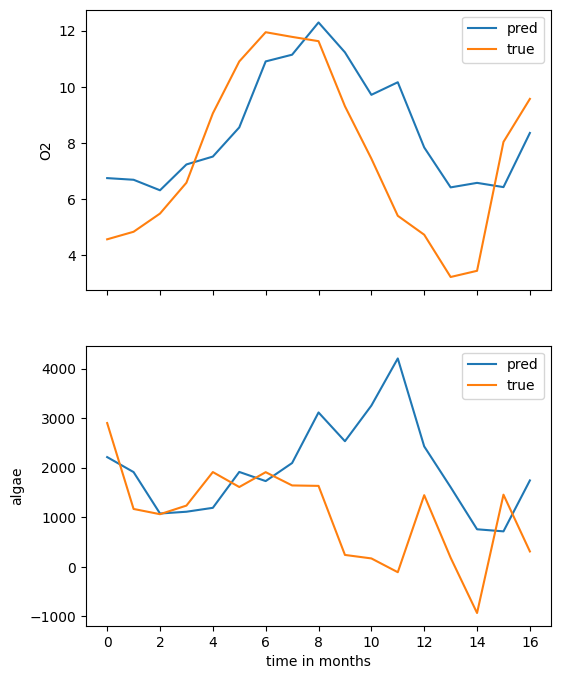

In [8]:
model = LinearRegression(lambda_=0.0, feature_type="lin", lag=False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test[:-1], Y_test[:-1])
Y_true = Y_test[1:]

rmse = np.sqrt(np.mean((Y_true - Y_pred) ** 2, axis=0))
print(f"RMSE (Dissolved oxygen): {rmse[0]}")
print(f"RMSE (Algae): {rmse[1]}")

plot_output_states(Y_pred, Y_true)

3\) Evaluate the `LinearRegression` model for different $\lambda$ values. Create a plot that shows the mean RMSE of the two predicted states and the $\lambda$ values.

You should also play with the other hyperparameters like `feature_type` and `lag` and test which ones give the lowest prediction error.

Plot the true and predicted output variables over time for the best `lambda_` parameter.

RMSE of best model: O2= 3.31,alge=1250.11,with hyperparameter: (3000000.0, 'lin', False)


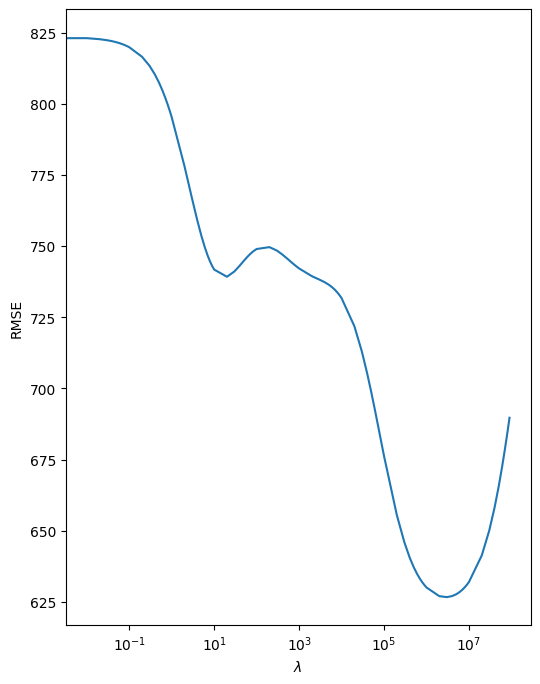

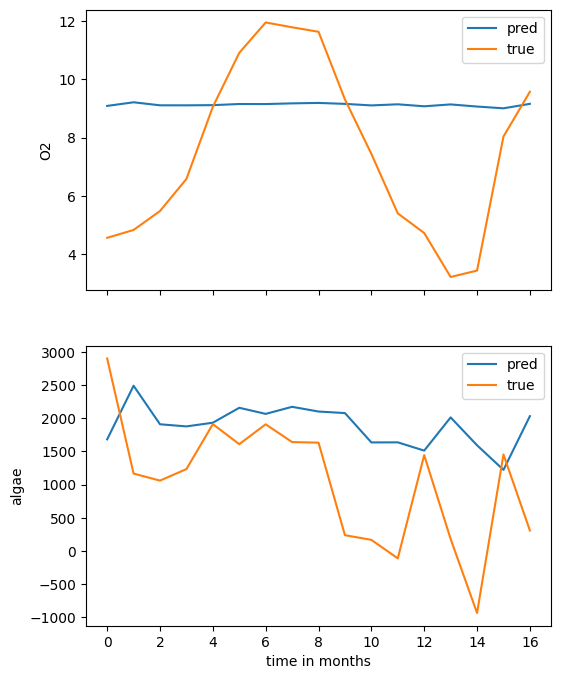

In [9]:
rmse_list = []
Y_pred_list = []

log_lambdas = np.outer(10.0 ** np.arange(-2, 8), np.arange(1, 10, 1)).ravel()
lambdas = np.hstack(
    (0.0, log_lambdas)
)  # add zero to show regression without regularization
feature_types = ["lin"]
lags = [False]
hyperparameters = [
    (lamb, feature_type, lag)
    for lamb in lambdas
    for feature_type in feature_types
    for lag in lags
]

for par in hyperparameters:
    model = LinearRegression(lambda_=par[0], feature_type=par[1], lag=par[2])
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test[:-1], Y_test[:-1])
    if par[2]:  # lag True
        Y_true = Y_test[2:]
    else:
        Y_true = Y_test[1:]
    rmse = np.sqrt(np.mean((Y_true - Y_pred) ** 2, axis=0))

    rmse_list.append(rmse)
    Y_pred_list.append(Y_pred)

best_model_pos = np.array([np.mean(rmse) for rmse in rmse_list]).argmin()
print(
    f"RMSE of best model: O2= {rmse_list[best_model_pos][0]:.2f},"
    f"alge={rmse_list[best_model_pos][1]:.2f},"
    f"with hyperparameter: {hyperparameters[best_model_pos]}"
)

# plot lambda values over the mean rmse
fig, ax = plt.subplots(figsize=(6, 8))
ax.semilogx(lambdas, [np.mean(rmse) for rmse in rmse_list])
ax.set_ylabel("RMSE")
ax.set_xlabel("$\lambda$")

# plot the states of the best model
plot_output_states(Y_pred_list[best_model_pos], Y_true)